<a href="https://colab.research.google.com/github/atharvved09/Bioinformatics-DB/blob/master/04_community_diversity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 04: Comparing microbial community structures

- Author: Daniel McDonald

---

## Background

In this workshop section, we will focus on beta-diversity using UniFrac, on the 16S rRNA V4 data from the EMP500 dataset. We will apply UniFrac which is a popular phylogenetic beta-diversity metric. The similarity computed is the **uni**que **frac**tion of the phylogenetic branch length between a pair of samples. Then, we will perform Principal Coordinates Analysis to visualize the primary axes of variation among samples. We will then apply PERMANOVA to test for significant differences among groups of samples.

Last, to further explore the capabilities of scikit-bio, we will  test whether sample similarities are correlated between two prevalent phyla using both a Mantel test and Procrustes analysis.

## Learning objectives

In this section of the workshop, you will learn how to:

* Filter and rarefy a feature table
* Run UniFrac programmatically
* Apply Principal Coordinates Analysis, and visualize the resulting coordinates
* Perform PERMANOVA, Mantel and Procustes tests
* Use the TreeNode to identify common phyla, and constrain subsequent analyses based on the subtrees

## Preparation

Install the latest version of scikit-bio if it hasn't been (needed for every Google Colab instance).

In [1]:
from importlib.util import find_spec

In [2]:
if find_spec('skbio') is None:
    !pip install -q scikit-bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 55.9 MB/s eta 0:00:00


In [3]:
import skbio
skbio.__version__

'0.7.1.post1'

Download the EMP500 dataset and unzip it. (If you have done it already, skip the following code.)

In [4]:
!wget -q -O emp500.tar.gz "https://www.dropbox.com/scl/fi/7sepykr3vhss60647osc8/emp500.tar.gz?rlkey=6q5ac48noeax5n2htaqslvo8g&dl=0"
!tar zxf emp500.tar.gz

In [5]:
HOME = 'emp500'

Check if the directory exists by listing its content.

In [6]:
!ls $HOME

amplicon  assembly  masspec  README.md	sample.tsv  shotgun


Import Matplotlib for plotting.

In [7]:
import matplotlib.pyplot as plt

Mute warnings.

In [8]:
import warnings
warnings.filterwarnings('ignore')

Before we can do anything exciting, we need to load the various pieces of data into memory.

First, we're going to load the phylogeny into the `TreeNode` object. A `TreeNode` provides a rich set of methods for interacting with phylogeny, including operations to traverse, compare trees, aggregate information, collect subtrees and more. Later on in the Notebook, we will show an example of aggregating information up a tree, following by collecting tips from specific clades.

In [9]:
from skbio import TreeNode

In [10]:
phylogeny = skbio.TreeNode.read(f'{HOME}/amplicon/subset/16s_labeled.nwk', format='newick')

Next, we're going to load the feature table into the `Table` object. Often, feature tables are quite sparse -- in the American Gut Project, we observe < .1% of values in a feature table are non-zero. To account for the sparsity, this object represents the matrix of sample / feature counts using a sparse matrix representation which only stores the non-zero data. Like the `TreeNode`, the `Table` object has a rich set of methods for filtering, transforming, collapsing, partitioning, subsampling (i.e., rarefaction) and more.

In [11]:
from skbio import Table

In [12]:
table = Table.read(f'{HOME}/amplicon/subset/16s.biom')

Last, we will load the sample metadata, which has been discussed in prior sections. We will focus on the `empo_1` category which describes whether a sample is host associated or environmental, so we'll pull that column out upfront.

In [13]:
from skbio import SampleMetadata

In [14]:
metadata = SampleMetadata.load(f'{HOME}/sample.tsv')

In [15]:
empo_1 = metadata.get_column('empo_1').to_series()

## Rarefaction

UniFrac is sensitive to uneven sequencing effort among samples. To account for this, we will rarefy the table a single time. In interests of simplifying compute in the tutorial, we will rarefy to a fairly shallow level of 100 sequences per sample. However, as we will see, this shallow depth is still sufficient to differentiate a high effect size variable like whether a sample is host associated or environmental.

**NOTE**: Not all diversity calculations are sensitive to sequencing depth. However, with those other metrics such as [RPCA](https://journals.asm.org/doi/10.1128/msystems.00016-19) and [Phylo-PRCA](https://journals.asm.org/doi/10.1128/msystems.00050-22) it may still be important to remove samples with too few sequences.



In [16]:
depth = 100
even_table = table.subsample(depth)

While not strictly necessary, we will remove unnecessary vertices and edges from the phylogeny relative to the rarefied table. Doing so reduces the compute for UniFrac later on.

**NOTE**: scikit-bio is the reference implementation for [Fast UniFrac](https://www.nature.com/articles/ismej200997). However, subsequent large [algorithmic improvements](https://journals.asm.org/doi/10.1128/msystems.00028-22) have been developed. This advanced variant will be included directly in scikit-bio in the future.

In [17]:
even_phylogeny = phylogeny.shear(set(even_table.ids(axis='observation')))

## UniFrac distance

Let's go ahead and run UniFrac now.

If you're unfamiliar with UniFrac, it is a [distance metric](https://www.nature.com/articles/ismej2010133) that computes a distance between two samples based on the amount of unique branch length within each sample. For example, given a sample composed entirely of Archaea, and a sample composed entirely of Bacteria, all branches of the tree would be unique to each sample, leading to a maximal distance of 1.0. In constrast, a sample composed of *Prevotella* and *Bacteroides*, and a sample composed of *Lactobacillus* and *Faecalibacterium*, would have a fair amount of shared branches with fewer branches unique to a sample -- the distance between them would be far less than 1.0. The original UniFrac algorithm is described [here](https://journals.asm.org/doi/10.1128/aem.71.12.8228-8235.2005).

In [18]:
from skbio.diversity import beta_diversity

In [19]:
full_dm = beta_diversity('unweighted_unifrac', even_table, tree=even_phylogeny)

The subsequent `DistanceMatrix` object has support methods for pulling interesting sets of distances. Let's take a quick look at obtaining distances "within" a group, and contrast them to the distances "between" two groups.


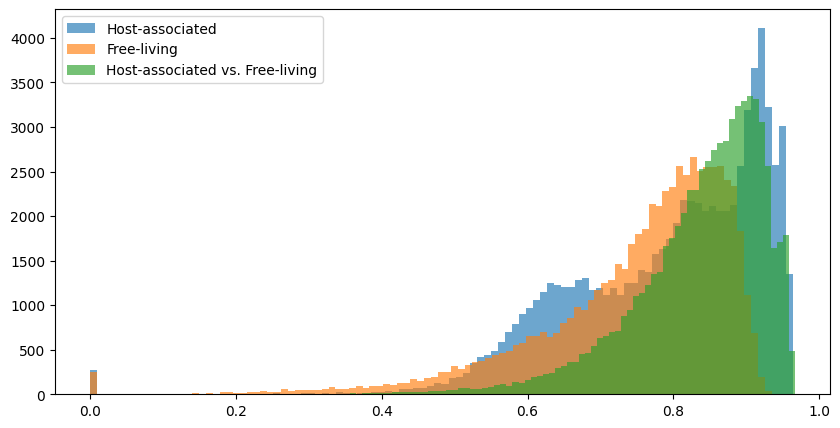

In [20]:
plt.figure(figsize=(10, 5))

empo_1 = empo_1.loc[list(full_dm.ids)]

labels = []
for env in empo_1.unique():
    env_ids = set(empo_1[empo_1 == env].index)
    within_data = full_dm.within(env_ids)
    plt.hist(within_data['value'], alpha=0.65, bins=100)
    labels.append(env)

from_label, to_label = empo_1.unique()
from_ = empo_1[empo_1 == from_label].index
to_ = empo_1[empo_1 == to_label].index

between_data = full_dm.between(from_, to_)
plt.hist(between_data['value'], alpha=0.65, bins=100)
labels.append(f'{from_label} vs. {to_label}')

plt.legend(labels);

## PCoA and PERMANOVA

Let's now move on to [Principal Coordinates Analysis](https://en.wikipedia.org/wiki/Multidimensional_scaling#Classical_multidimensional_scaling) (PCoA). PCoA is a dimensionality reduction technique, which allows us to examine the primary axes of variation in a dataset. The scikit-bio implementation is based on [Legendre & Legendre](https://shop.elsevier.com/books/numerical-ecology/legendre/978-0-444-89249-2), but scikit-bio also supports an approximate version of PCoA, where the number of dimensions calculated is parameterized, and is scalable to quite large datasets.

As we'll see, the `OrdinationResults` object has a few member methods, including a `DataFrame` representation of the coordinate data.

In [21]:
from skbio.stats.ordination import pcoa

In [22]:
pc = pcoa(full_dm, number_of_dimensions=10)

In [23]:
pc.proportion_explained

,0
PC1,0.176710
PC2,0.116035
PC3,0.062245
PC4,0.051362
PC5,0.036387
PC6,0.034975
PC7,0.029791
PC8,0.025818
PC9,0.024335
PC10,0.020625


In [24]:
pc.samples.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
13114.song.51.s009,0.051797,0.007104,-0.155512,-0.019503,-0.131135,-0.223991,-0.109013,0.037656,-0.319396,0.053367
13114.minich.76.s006,-0.164772,0.105515,-0.248985,-0.076610,-0.094407,-0.064292,0.028268,-0.056004,0.076184,0.198041
13114.stegen.38.s015,-0.119137,-0.360221,0.178243,-0.012141,-0.016083,-0.074956,0.025898,0.219287,0.063052,-0.036433
13114.mousseau.88.s056,0.346796,0.088116,-0.068160,-0.011184,-0.032293,-0.060418,-0.114268,-0.024128,0.057697,0.029875
13114.king.27.s017,-0.115217,0.053692,-0.366817,-0.166495,0.100300,0.057202,-0.046351,-0.080456,-0.006904,-0.158613


Using the coordinates, we can make a single scatter plot of the samples.

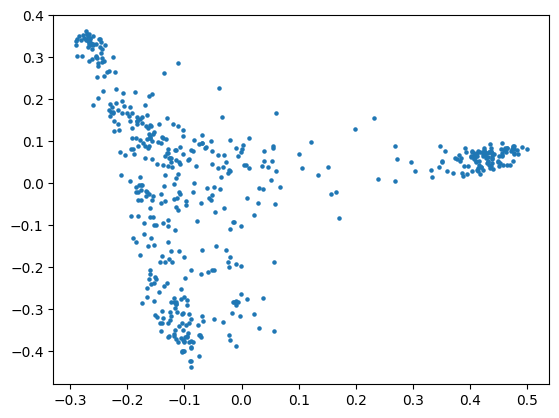

In [25]:
plt.scatter(pc.samples['PC1'], pc.samples['PC2'], s=5);

...but that's not that interesting. Let's add some color. We're going to do this a couple of times so let's write a small function.

**NOTE**: We also recommend [EMPeror](https://academic.oup.com/gigascience/article/2/1/2047-217X-2-16/2656132) for large scale visualization. It is compatible with the `OrdinationResults` object, supports interactive operation and various brushing options.  

In [26]:
def pcoa_plot(ord_result, metadata, category, title=None):
    plt.figure(figsize=(7, 7))

    # adjust the point size based on the number of samples
    if len(ord_result.samples) > 300:
        s = 5
    else:
        s = 10

    labels = []

    ord_ids = set(ord_result.samples.index)
    category_series = metadata.get_column(category).to_series()
    for env in category_series.unique():
        labels.append(env)

        env_ids = metadata.get_ids(where=f"[{category}] = '{env}'")
        env_ids = list(env_ids & ord_ids)

        plt.scatter(ord_result.samples.loc[env_ids, 'PC1'],
                    ord_result.samples.loc[env_ids, 'PC2'],
                    s=s, alpha=0.75)
    ax = plt.gca()
    ax.set_xlabel(f'PC1 ({100 * (ord_result.proportion_explained[0]):.2f}%)')
    ax.set_ylabel(f'PC2 ({100 * (ord_result.proportion_explained[1]):.2f}%)')
    plt.legend(labels)
    if title is not None:
        plt.title(title)

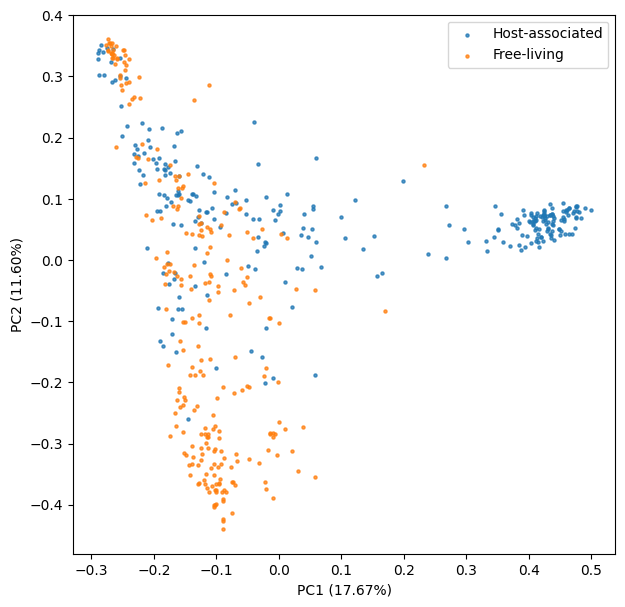

In [27]:
pcoa_plot(pc, metadata, 'empo_1')

To support the above analyses, we will apply [PERMANOVA](https://onlinelibrary.wiley.com/doi/10.1111/j.1442-9993.2001.01070.pp.x) to the distances. PERMANOVA is a non-parametric analysis of variance. By default, PERMANOVA computes 999 permutations which is used to estimate the p-value.

In [28]:
from skbio.stats.distance import permanova

In [29]:
permanova(full_dm, empo_1)

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,526
number of groups,2
test statistic,40.334707
p-value,0.001
number of permutations,999


## Incorporating phylogeny

Now, let's tinker.

We might wonder whether the sample-to-sample relationships are consistent when constrained to particular phyla.

To do this, we're going to aggregate sample information up the phylogeny (from tip to root). Specifically, we are going to determine the set of samples a feature is present in, and then push the unique sample IDs up the tree through a postorder traversal, effecively reducing the information.

While doing so, we are also going to cache the names of the features found within a clade simply to facilitate filtering later on.



In [30]:
sample_ids = even_table.ids()

# this complex dict comprehension maps a feature ID to the set of
# samples that feature was found it. The v.indices attribute is the
# index positions of the nonzero values within a SciPy sparse vector
samples_represented = {id_: set(sample_ids[v.indices])
                       for v, id_, _ in even_table.iter(axis='observation', dense=False)}

Postorder means children are assured to be evaluted before parents. The TreeNode supports many types of traversals, and pleasant examples of common traversals can be found on [Wikipedia](https://en.wikipedia.org/wiki/Tree_traversal). Here, we will decorate these new attributes onto the tree.

The algorithm is:
1. if the object being evaluated is a tip
* get the samples represnted (or the empty set)
* construct a set composed of only the feature name
2. else the object must be an internal node
* compute the set union of samples represented
* compute the set union of features represented

In [31]:
from functools import reduce
from operator import or_

In [32]:
for node in phylogeny.postorder():
    if node.is_tip():
        node.samples_represented = samples_represented.get(node.name, set())
        node.tips_represented = {node.name, }
    else:
        node.samples_represented = reduce(or_, [child.samples_represented for child in node.children])
        node.tips_represented = reduce(or_, [child.tips_represented for child in node.children])

Let's spot check what the representation is at the domain level.

In [33]:
for child in phylogeny.children:
    print(f"Samples with {child.name}: {len(child.samples_represented)}")

Samples with d__Bacteria: 526
Samples with d__Archaea: 61


Next, let's gather all phylum level named nodes (p__), sort them by how many samples are represented, and print the top few

In [34]:
from operator import itemgetter

In [35]:
named_nodes = [(n.name, len(n.samples_represented), n)
               for n in phylogeny.traverse()
               if n.name is not None and n.name.startswith('p__')]

named_nodes = sorted(named_nodes, key=itemgetter(1), reverse=True)
for name, count, _ in named_nodes[:10]:
    print(f"Samples with {name}: {count}")

Samples with p__Proteobacteria: 520
Samples with p__Firmicutes_D: 464
Samples with p__Bacteroidota: 416
Samples with p__Cyanobacteria: 409
Samples with p__Firmicutes_A: 402
Samples with p__Actinobacteriota: 384
Samples with p__Verrucomicrobiota: 203
Samples with p__Acidobacteriota: 187
Samples with p__Deinococcota; c__Deinococci: 152
Samples with p__Planctomycetota: 143


In [36]:
# A helper function to intersect a table with the features represented by a node

def intersect_with_node(tab, node):
    tips_in_table = set(tab.ids(axis='observation'))
    tipset = node.tips_represented & tips_in_table
    return tab.filter(tipset, axis='observation', inplace=False).remove_empty()

Now we will take two interesting sets. While testing this notebook, it was noted the number of sample IDs in common between Proteobacteria and Firmicutes_D, after rarefaction, was relatively low. So instead, let's look at Proteobacteria and Bacteroidota.

The next few cells filter the feature table to each phyla of focus, constrain them to the exact same set of IDs, compute UniFrac again, and then principal coordinates.

In [37]:
first_name, _, first_node = named_nodes[0]
second_name, _, second_node = named_nodes[2]

even_table_first = intersect_with_node(table, first_node).subsample(depth)
even_table_second = intersect_with_node(table, second_node).subsample(depth)

In [38]:
common_ids = set(even_table_first.ids()) & set(even_table_second.ids())
even_table_first = even_table_first.filter(common_ids).remove_empty()
even_table_second = even_table_second.filter(common_ids).remove_empty()

In [39]:
first_dm = beta_diversity('unweighted_unifrac', even_table_first, tree=phylogeny)
second_dm = beta_diversity('unweighted_unifrac', even_table_second, tree=phylogeny)

In [40]:
first_pc = pcoa(first_dm, number_of_dimensions=10)
second_pc = pcoa(second_dm, number_of_dimensions=10)

Now we can visualize these clade specific beta diversity calculations!

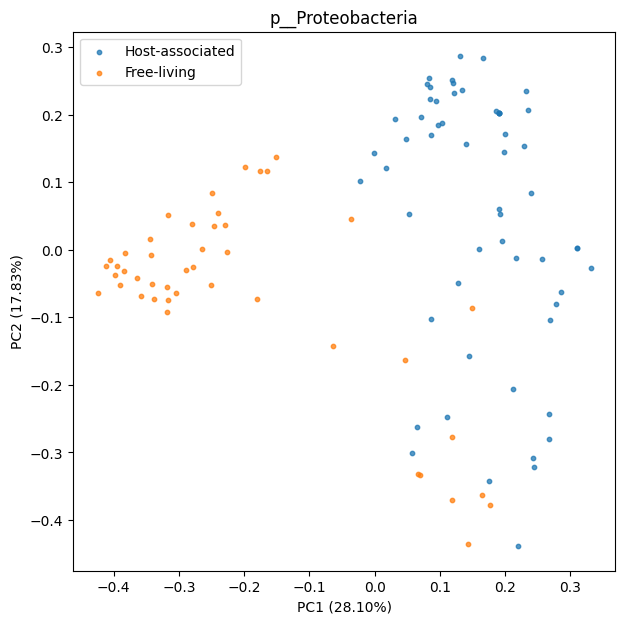

In [41]:
pcoa_plot(first_pc, metadata, 'empo_1', first_name)

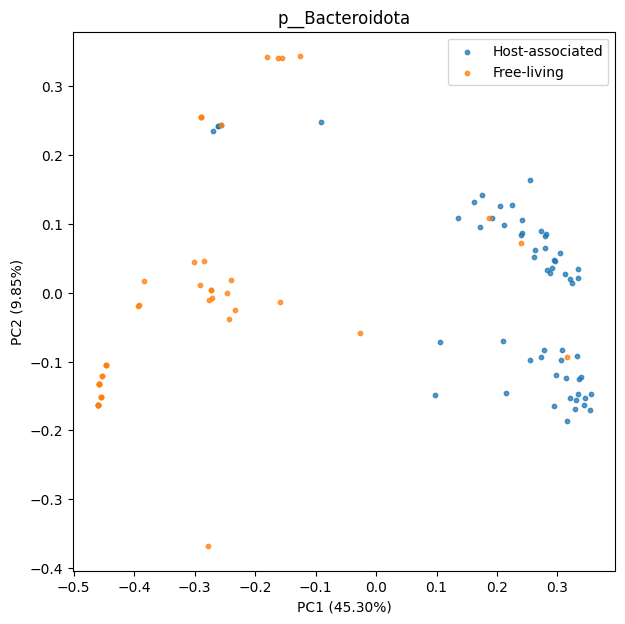

In [42]:
pcoa_plot(second_pc, metadata, 'empo_1', second_name)

## Mantel test

We additionally can compute the correlation of the sample-sample relationships in both phyla using a [Mantel](https://pubmed.ncbi.nlm.nih.gov/6018555/) test. Mantel, like PERMANOVA, is non-parametric and by default uses 999 repetitions to estimate a p-value.

In the next few cells, we will compare Proteobacteria to Bacteroidota, Proteobacteria to the full tree, and Bacteroidota to the full tree. We then will apply PERMANOVA to these clade specific distance matrices.

Interestingly, we observe a relatively low correlation between these two phyla, and it seems the sample-sample relationships within Bacteroidota better recapitulate the full distance matrix. This observation is further supported by the relative difference in test statistics from PERMANOVA, where the statistic is larger between host and non-host samples.

In [43]:
from skbio.stats.distance import mantel

In [44]:
r, p, _ = mantel(first_dm, second_dm)
print(f"Mantel r={r:0.2} p={p:0.2}")

Mantel r=0.47 p=0.001


In [45]:
r, p, _ = mantel(full_dm, first_dm, strict=False)
print(f"Mantel r={r:0.2} p={p:0.2}")

Mantel r=0.65 p=0.001


In [46]:
r, p, _ = mantel(full_dm, second_dm, strict=False)
print(f"Mantel r={r:0.2} p={p:0.2}")

Mantel r=0.78 p=0.001


In [47]:
permanova(first_dm, empo_1)

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,103
number of groups,2
test statistic,25.42417
p-value,0.001
number of permutations,999


In [48]:
permanova(second_dm, empo_1)

,PERMANOVA results
method name,PERMANOVA
test statistic name,pseudo-F
sample size,103
number of groups,2
test statistic,48.685975
p-value,0.001
number of permutations,999


## Proscrustes disparity

And last, we will compute the [Procrustes disparity](https://en.wikipedia.org/wiki/Procrustes_analysis), a measure of fit, between the clade specific ordinations.

Procrustes can also be permuted to estimate a p-value, however that is not directly supported at this time within scikit-bio. The procedure is relatively simple though: iterate N times, randomly shuffle the IDs of one of the matrices, recomptue Procrustes. This too is slated for inclusion directly in scikit-bio. And last, the EMPeror library (noted above) can plot Procrustes transforms linking the samples in both ordinations visually.

In [49]:
from scipy.spatial import procrustes

In [50]:
mtx1, mtx2, disparity = procrustes(
    first_pc.samples[['PC1', 'PC2']],
    second_pc.samples[['PC1', 'PC2']]
)
print(disparity)

0.4221204524074751
